# About the Project:


PyEmailAuto is a simple ETL and Reporting automation project. 


## Read Libraries

In [11]:
import pandas as pd
import os

from random import randint
from pretty_html_table import build_table
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.base import MIMEBase
from email import encoders 
from email.mime.application import MIMEApplication


import warnings
warnings.filterwarnings('ignore')

## Load Data 

* You can load data from various sources
* Read CSV files
* Use mysql connector or any API to connect to databases and SELECT data
* or even by crawling websites

In [12]:
# Here we just generate some random number as our data source
# In this example we are reporting last week revenue in comparison with the week before that

week_day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
revenue_week_current = [randint(4000,7000) for i in range(len(week_day))]
revenue_week_before = [randint(4000,7000) for i in range(len(week_day))]

df_revenue_current = pd.DataFrame({"Weekday":week_day,"revenue":revenue_week_current})
df_revenue_before = pd.DataFrame({"Weekday":week_day,"revenue":revenue_week_before})

## Transform Data 

Data is reported in these formats:
* Total values and comparison with previous week in a text
* Daily value in a beautiful table format
* Daily values in graph format
* Both tables are printed in an excel file and will be attached to the email

In [13]:
# Here are some useful function to transform data into different formats

# get_total gets the whole week revenue and change the number to a readable string format
def get_total(df_revenue):
    total_value = df_revenue["revenue"].sum()
    payment_string = "{:,} $".format(int(total_value))
    
    return payment_string , total_value



# diff_percent return the difference between two weeks revenue
def diff_percent(value1 , value2):
    diff_p = int(round((value1/value2 -1)*100 , 0))
    
    return diff_p


def print_tables_excel(table_list,table_names):
    excel_file = "Some_Sample_Data.xlsx"
    writer = pd.ExcelWriter(excel_file, engine='xlsxwriter')
    start_row = 1
    workbook  = writer.book


    for tb in table_list:
        
        # change values to the comma separate format
        tb["Revenue ($)"] = ["{:,}".format(int(item)) for item in tb["revenue"]]
        
        # Set values align in center of cells 
        start_row += 1
        tb[['Weekday',"Revenue ($)"]].style.set_properties(**{'text-align': 'center'}).to_excel(writer, startrow = start_row, sheet_name='revenue', index=False)
        start_row += len(tb)+3
        #Iterate through each column and set the width to max value+2
        worksheet = writer.sheets['revenue']

        for i, col in enumerate(tb[['Weekday',"Revenue ($)"]].columns):
            column_len = tb[['Weekday',"Revenue ($)"]][col].astype(str).str.len().max()
            column_len = max(column_len, len(col)) + 2
            worksheet.set_column(i, i, column_len)
            
    start_row = 1
    for i, tbn in enumerate(table_names):
        worksheet.write(start_row, 0, 'Revenue Values of  {}'.format(tbn), workbook.add_format({'bold': True, 'color': '#E26B0A', 'size': 14}))        
        start_row += len(table_list[i])+4
        
    writer.save()
    return excel_file


def make_beautiful(df_week):
    
    df_week["Revenue ($)"] = ["{:,}".format(int(item)) for item in df_week["revenue"]]
    pretty_table =  build_table(df_week[["Weekday" , "Revenue ($)"]], 'blue_light' ,  text_align='center' ,font_size=12 )
    
    return pretty_table


def plot_graph(df_table1):
    
    sns.set()
    fig , ax = plt.subplots(figsize = (10,6))
    ax.bar(df_table1["Weekday"], df_table1.revenue.values, color = 'b' ,width =0.5 )
    ax.get_yaxis().set_major_formatter(
        FuncFormatter(lambda x, p: format(int(x), ',')+" $"))
    for index, row in df_table1.iterrows():
        ax.text(row.Weekday,row.revenue,  "{:,}".format(int(row.revenue)) ,
             color='black', ha="center" ,fontsize=2*len(df_table1) )
    ax.grid(False)
    title_text = 'Last Week Revenue ($)'
    plt.title(title_text)
    image_name = "Last_Week_Revenue.png"
    plt.savefig(image_name)
    return image_name
    



The total revenue of this week was: 35,988 $


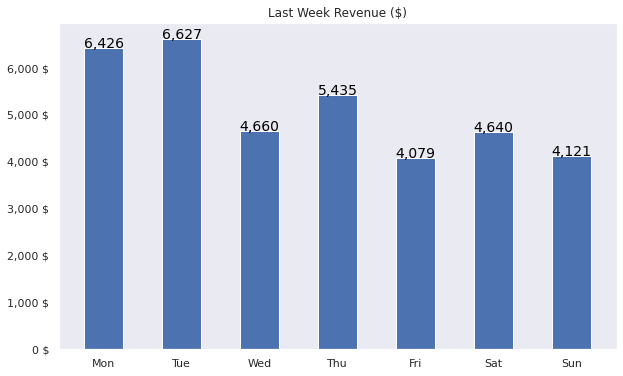

In [14]:
# Now it's time to transform data

payment_string_current,total_value_current = get_total(df_revenue_current)
print("The total revenue of this week was: {}".format(payment_string_current))

payment_string_before,total_value_before = get_total(df_revenue_before)


diff_p = diff_percent(total_value_current , total_value_before)

excel_file = print_tables_excel([df_revenue_current , df_revenue_before],["This Week ($)" , "Previous Week ($)"])

pretty_table = make_beautiful(df_revenue_current)

image_name = plot_graph(df_revenue_current )



## Load Data

Here whrere you send all the report material via email.
There are some tips to do this:
* Don't use your personal email address 
* You may need to make some changes in the email account setting to use this api
* There are lots of other report format that you can use. Be creative and Automate Insightful Data Reports.

In [15]:
mail_content = '''
    Dear All
    
    Here is the total revenue of last week:   {} . 
    In comparison to the previous week, we had {}% growth in the revenue payment.
    
    Bests,
    Reporting Team
    
'''.format(payment_string_current , diff_p)    

#Put sender email address and password here 
sender_address = 'report.email@mail.com'
sender_pass = 'reportemailpassword'


receiver_address = ['sfa.mousavi@gmail.com']

#Setup the MIME
message = MIMEMultipart()
message['From'] = sender_address
message['To'] = ", ".join(receiver_address)
message['Subject'] = 'Automate Report of Last Week'

#The body and the attachments for the mail
message.attach(MIMEText(mail_content, 'plain'))
attach_file_name = excel_file
payload=MIMEApplication(open(attach_file_name,"rb").read())
encoders.encode_base64(payload) #encode the attachment
payload.add_header('Content-Disposition', 'attachment', filename=attach_file_name)
message.attach(payload)

ImgFileName = image_name
with open(ImgFileName, 'rb') as f:
    img_data = f.read()
    image = MIMEImage(img_data, name=os.path.basename(ImgFileName))
    message.attach(image)

# And  add that pretty table
message.attach(MIMEText(pretty_table, "html"))


session = smtplib.SMTP('smtp.gmail.com', 587) #use gmail with port
session.starttls() #enable security
session.login(sender_address, sender_pass) #login with mail_id and password
text = message.as_string()
session.sendmail(sender_address, receiver_address, text)
session.quit()
print('Mail Sent')

 
    


Mail Sent
